In [81]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [82]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [83]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [84]:
content_path = tf.keras.utils.get_file('melanoma_mat', 'https://www.euromelanoma.org/sites/default/files/styles/original/public/resources/gallery/Melanoma/Melanoma%2028.JPG?itok=5LzAxIxA')
style_path = tf.keras.utils.get_file('skin tone texture','https://t3.ftcdn.net/jpg/02/82/74/28/360_F_282742880_HphDxd24pb2h5BfnX4AkYCrNflOTjbSq.jpg')

In [85]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [86]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

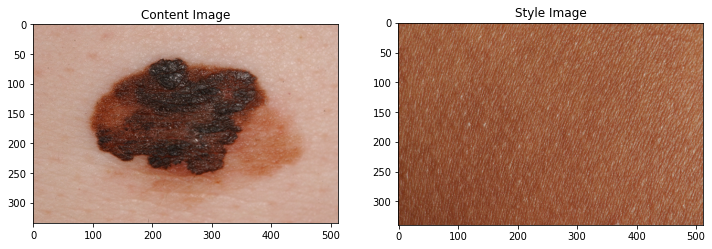

In [87]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [88]:
# preprocess
mean = np.mean(content_image, axis=(0, 1, 2))
std = np.std(content_image, axis=(0, 1, 2))
print("Mean: [{0:.4f}, {1:.4f}, {2:.4f}]".format(mean[0], mean[1], mean[2]))
print("STD: [{0:.4f}, {1:.4f}, {2:.4f}]".format(std[0], std[1], std[2]))
content_image -= mean
content_image /= std
content_image = content_image[:,:224,:224,:]

Mean: [0.6751, 0.5190, 0.4557]
STD: [0.2031, 0.1988, 0.1943]


In [89]:
mean = np.mean(style_image, axis=(0, 1, 2))
std = np.std(style_image, axis=(0, 1, 2))
print("Mean: [{0:.4f}, {1:.4f}, {2:.4f}]".format(mean[0], mean[1], mean[2]))
print("STD: [{0:.4f}, {1:.4f}, {2:.4f}]".format(std[0], std[1], std[2]))
style_image -= mean
style_image /= std
style_image = style_image[:,:224,:224,:]

Mean: [0.6078, 0.3671, 0.2500]
STD: [0.0548, 0.0802, 0.0832]


In [90]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
# Block 1
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', strides=(1, 1), activation='relu', name="block1_conv1"))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=(1, 1), activation='relu', name="block1_conv2"))
model.add(MaxPool2D(pool_size=(2, 2), name="block1_pool"))

# Block 2
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1), activation='relu', name="block2_conv1"))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1), activation='relu', name="block2_conv2"))
model.add(MaxPool2D(pool_size=(2, 2), name="block2_pool"))

# Block 3
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=(1, 1), activation='relu', name="block3_conv1"))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=(1, 1), activation='relu', name="block3_conv2"))
model.add(MaxPool2D(pool_size=(4, 4), name="block3_pool"))
model.add(Dropout(rate=0.3, name="block3_dropout"))

# if dense:
    # Block 4
model.add(Flatten(name="block4_flatten"))
model.add(Dense(units=512, activation='relu', name="block4_dense"))

# Block 5
model.add(Dense(units=9, activation='softmax', name="block5_dense"))

In [91]:
content_image = content_image[:,:224,:224,:]

my_model = model
my_model(tf.zeros((1,224,224,3)))
my_model.load_weights("../checkpoints/alex.weights.e019-acc0.4322.h5")
prediction_probabilities = my_model(content_image)
prediction_probabilities.shape
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (1, 224, 224, 32)         2432      
_________________________________________________________________
block1_conv2 (Conv2D)        (1, 224, 224, 32)         9248      
_________________________________________________________________
block1_pool (MaxPooling2D)   (1, 112, 112, 32)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (1, 112, 112, 64)         18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (1, 112, 112, 64)         36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (1, 56, 56, 64)           0         
_________________________________________________________________
block3_conv1 (Conv2D)        (1, 56, 56, 128)         

In [92]:
for layer in my_model.layers:
    print(layer.name)

block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_pool
block3_dropout
block4_flatten
block4_dense
block5_dense


In [93]:
content_layers = ['block3_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [94]:
def vgg_layers(my_model, layer_names):
  my_model(tf.zeros((1, 224,224,3)))
  my_model.load_weights("../checkpoints/alex.weights.e019-acc0.4322.h5")
  my_model(tf.ones((1, 224,224,3)))
  outputs = [my_model.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([my_model.input], outputs)
  return model
  
style_extractor = vgg_layers(my_model, style_layers)


In [95]:
style_image = np.array(style_image)
style_image = style_image[:,:224,:224,:]

style_outputs = style_extractor(style_image*255)

In [96]:
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 224, 224, 32)
  min:  0.0
  max:  566.7122
  mean:  34.41823

block2_conv1
  shape:  (1, 112, 112, 64)
  min:  0.0
  max:  266.2896
  mean:  22.708294

block3_conv1
  shape:  (1, 56, 56, 128)
  min:  0.0
  max:  124.310234
  mean:  13.13321



In [97]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [98]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, my_model, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(my_model, style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)for style_output in style_outputs]

    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}
extractor = StyleContentModel(my_model, style_layers, content_layers)
results = extractor(tf.constant(content_image))

In [99]:
print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 32, 32)
    min:  1.038086
    max:  55883.188
    mean:  2179.0242

   block2_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  18422.234
    mean:  760.0781

   block3_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  8195.264
    mean:  213.37396

Contents:
   block3_conv2
    shape:  (1, 56, 56, 128)
    min:  0.0
    max:  225.09949
    mean:  6.4937696


In [100]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [101]:
image = tf.Variable(content_image)

In [102]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [103]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [104]:
style_weight=1e-2
content_weight=1e4

In [105]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [106]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

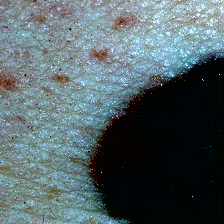

In [107]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [119]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

ValueError: in user code:

    /var/folders/16/kkyprxrn20xf2v1wxh68jkf40000gn/T/ipykernel_12735/4152216856.py:9 train_step  *
        opt.apply_gradients([(grad, image)])
    /Users/alexle/Desktop/cs1470/cs1470_env/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:630 apply_gradients  **
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    /Users/alexle/Desktop/cs1470/cs1470_env/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/utils.py:75 filter_empty_gradients
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['image:0'].


In [109]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

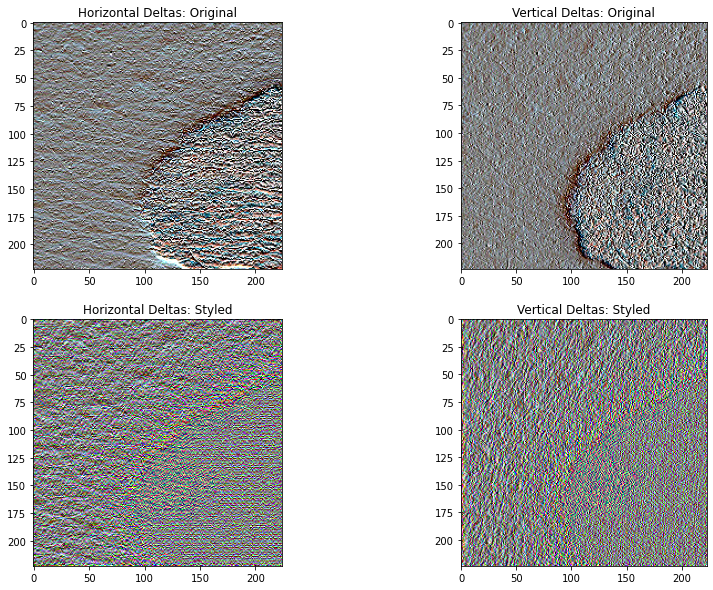

In [110]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [111]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [112]:
total_variation_loss(image).numpy()

70911.37

In [113]:
tf.image.total_variation(image).numpy()

array([70911.37], dtype=float32)

In [114]:
total_variation_weight=30

In [115]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [116]:
image = tf.Variable(content_image)

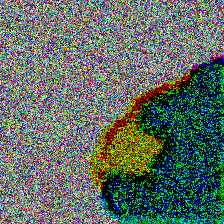

Train step: 100
..............................

KeyboardInterrupt: 

In [118]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image*255))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))